In [1]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import warnings

# Ignore warning messages
warnings.filterwarnings('ignore')

In [2]:
# List of stock symbols
symbols = ['VOO', 'VTI', 'VGT', 'VFH', 'VHT', 'VIS', 'VAW', 'VNQ']

# Initialize an empty DataFrame to hold all data
all_data = pd.DataFrame()

# Create a list to hold all dataframes
data_frames = []

# Get today's date
today = datetime.today().strftime('%Y-%m-%d')

# Get date 5 years ago
five_years_ago = (datetime.today() - timedelta(days=20*365)).strftime('%Y-%m-%d')

In [3]:
for symbol in symbols:
    # Fetch data for each stock
    try:
        data = yf.download(symbol, start=five_years_ago, end=today)
        
        # Add a column to specify the stock symbol
        data['Symbol'] = symbol

        # Append the data DataFrame to the list
        data_frames.append(data)
    except Exception as e:
        print(f"Failed to download {symbol}. Reason: {str(e)}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Concatenate all the dataframes in the list
all_data = pd.concat(data_frames)

# Save data to a CSV file
all_data.to_csv('stock_data.csv')

print("Data fetching is completed. Check the CSV file 'stock_data.csv' for the data.")

Data fetching is completed. Check the CSV file 'stock_data.csv' for the data.


In [5]:
df = pd.read_csv('stock_data.csv')
df.head()

# Create a dictionary with symbols and their names
symbol_to_name = {
    'VOO': 'Vanguard S&P 500 ETF',
    'VTI': 'Vanguard Total Stock Market ETF',
    'VGT': 'Vanguard Information Technology ETF',
    'VFH': 'Vanguard Financials ETF',
    'VHT': 'Vanguard Health Care ETF',
    'VIS': 'Vanguard Industrials ETF',
    'VAW': 'Vanguard Materials ETF',
    'VNQ': 'Vanguard Real Estate ETF'
}

# Create a new column 'Symbol_Name' mapping 'Symbol' to its name
df['Symbol_Name'] = df['Symbol'].map(symbol_to_name)

In [6]:
# Check datatypes
df.dtypes

Date            object
Open           float64
High           float64
Low            float64
Close          float64
Adj Close      float64
Volume           int64
Symbol          object
Symbol_Name     object
dtype: object

In [7]:
# Convert date to date dtype
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
# Check for any missing data
if df.isnull().sum().sum() == 0:
    print("No missing data in the dataset.")
else:
    print("There is missing data in the dataset.")

No missing data in the dataset.


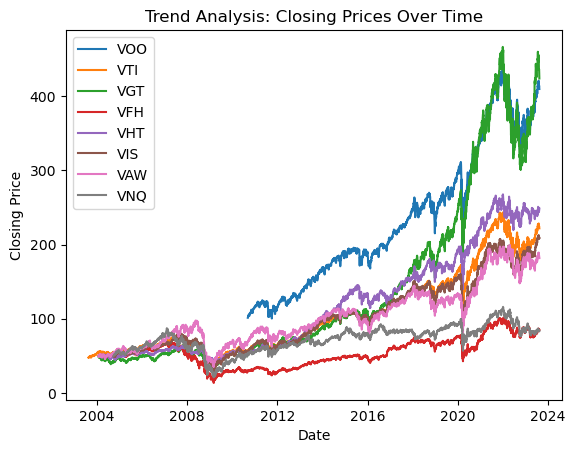

In [9]:
# Loop over each symbol and plot the 'Close' column over time
for symbol in symbols:
    stock_data = all_data[all_data['Symbol'] == symbol]
    plt.plot(stock_data.index, stock_data['Close'], label=symbol)

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Trend Analysis: Closing Prices Over Time')
plt.legend()
plt.show()

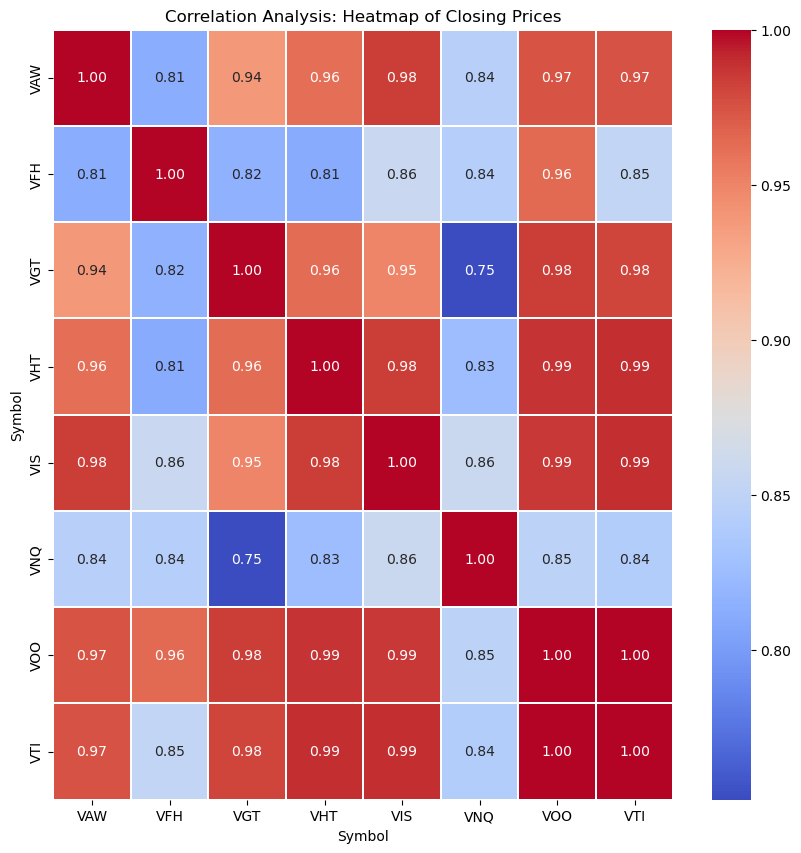

In [10]:
# Correlation Analysis
# Calculate correlation matrix
corr_matrix = all_data.pivot(columns='Symbol', values='Close').corr()

# Create a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.05)
plt.title('Correlation Analysis: Heatmap of Closing Prices')
plt.show()

In [11]:
# Split the dataset by symbols
data_by_symbol = {}
for symbol in symbols:
    data_by_symbol[symbol] = df[df['Symbol'] == symbol]

In [12]:
# Adding Technical Indicators

def compute_RSI(data, window=14):
    diff = data.diff()
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    up_chg[diff > 0] = diff[diff > 0]
    down_chg[diff < 0] = diff[diff < 0]
    
    up_chg_avg   = up_chg.rolling(window=window).mean()
    down_chg_avg = down_chg.abs().rolling(window=window).mean()
    
    rs = up_chg_avg / down_chg_avg
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [13]:
# Create a function to split data
def split_data(data):
    train = data.iloc[:-5]
    test = data.iloc[-5:]
    return train, test

In [14]:
# Create the prepare_data_for_lstm function
def prepare_data_for_lstm(data, look_back=1):
    # Get only 'Close' column
    data_series = data['Close']

    # Make the time series stationary by differencing
    diff = data_series.diff().dropna()

    # Scale the data to be between -1 and 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    diff_scaled = scaler.fit_transform(diff.values.reshape(-1, 1))

    X, Y = [], []
    for i in range(len(diff_scaled) - look_back):
        X.append(diff_scaled[i:(i + look_back), 0])
        Y.append(diff_scaled[i + look_back, 0])

    X, Y = np.array(X), np.array(Y)

    # Reshape X for model training
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Split data into train and test set
    X_train, X_test = X[:-5], X[-5:]
    y_train, y_test = Y[:-5], Y[-5:]

    return X_train, y_train, X_test, y_test, scaler

In [15]:
# Define a function to build and train LSTM
def build_and_train_lstm(X_train, y_train):
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model_lstm.add(LSTM(50, return_sequences=False))
    model_lstm.add(Dense(25))
    model_lstm.add(Dense(1))

    # Compile the model
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model_lstm.fit(X_train, y_train, batch_size=1, epochs=1)
    return model_lstm

In [16]:
# Initialize a dictionary to store results
results = {}
scaler = MinMaxScaler(feature_range=(-1, 1))

        Date        Open        High         Low       Close  Adj Close  \
0 2010-09-09  102.500000  102.500000  101.139999  101.320000  79.370003   
1 2010-09-10  101.680000  101.860001  101.300003  101.779999  79.730347   
2 2010-09-13  102.959999  103.139999  102.500000  103.059998  80.733047   
3 2010-09-14  102.839996  103.480003  102.379997  103.040001  80.717369   
4 2010-09-15  102.620003  103.379997  102.400002  103.300003  80.921051   

   Volume Symbol           Symbol_Name  SMA30  SMA100  RSI       EMA12  \
0   26500    VOO  Vanguard S&P 500 ETF    NaN     NaN  NaN  101.320000   
1    8600    VOO  Vanguard S&P 500 ETF    NaN     NaN  NaN  101.569166   
2   33750    VOO  Vanguard S&P 500 ETF    NaN     NaN  NaN  102.151038   
3   59400    VOO  Vanguard S&P 500 ETF    NaN     NaN  NaN  102.431649   
4    9250    VOO  Vanguard S&P 500 ETF    NaN     NaN  NaN  102.667577   

        EMA26      MACD  Signal_Line  
0  101.320000  0.000000     0.000000  
1  101.558845  0.010320   

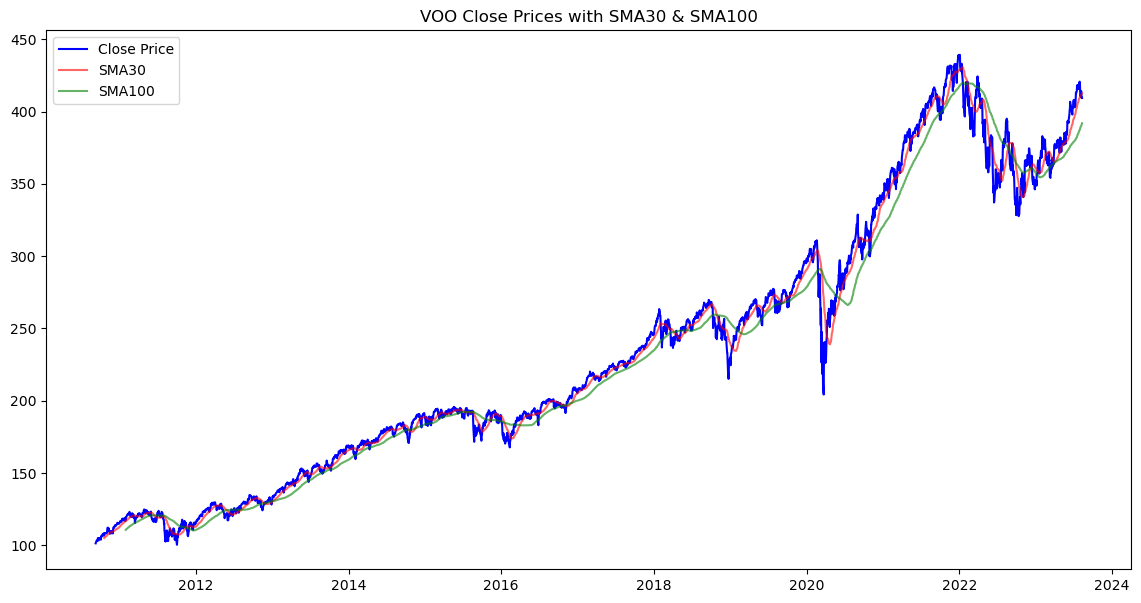

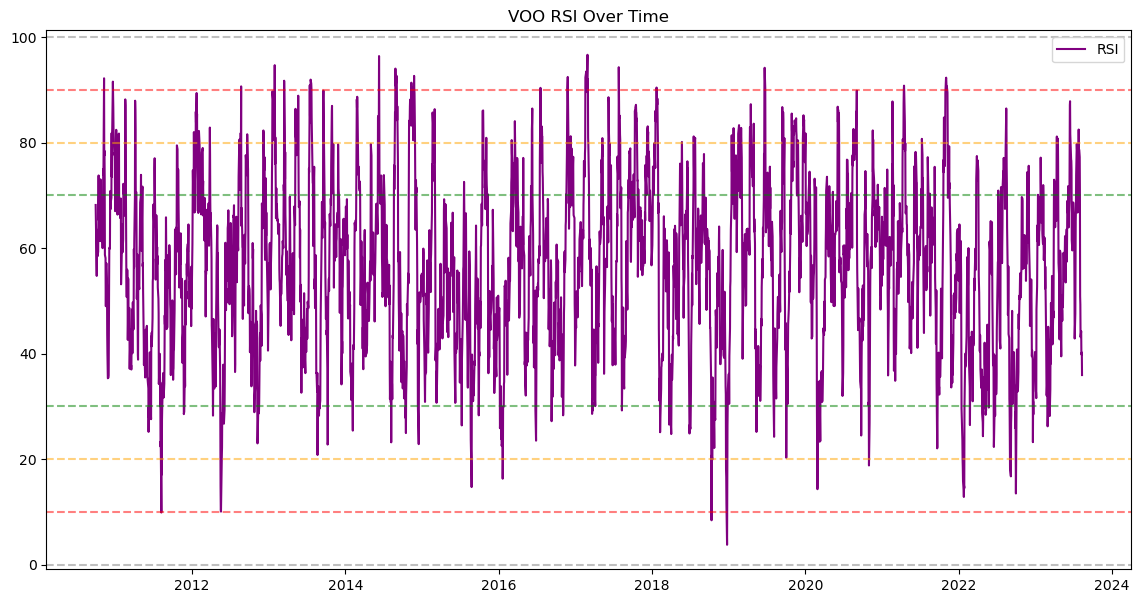

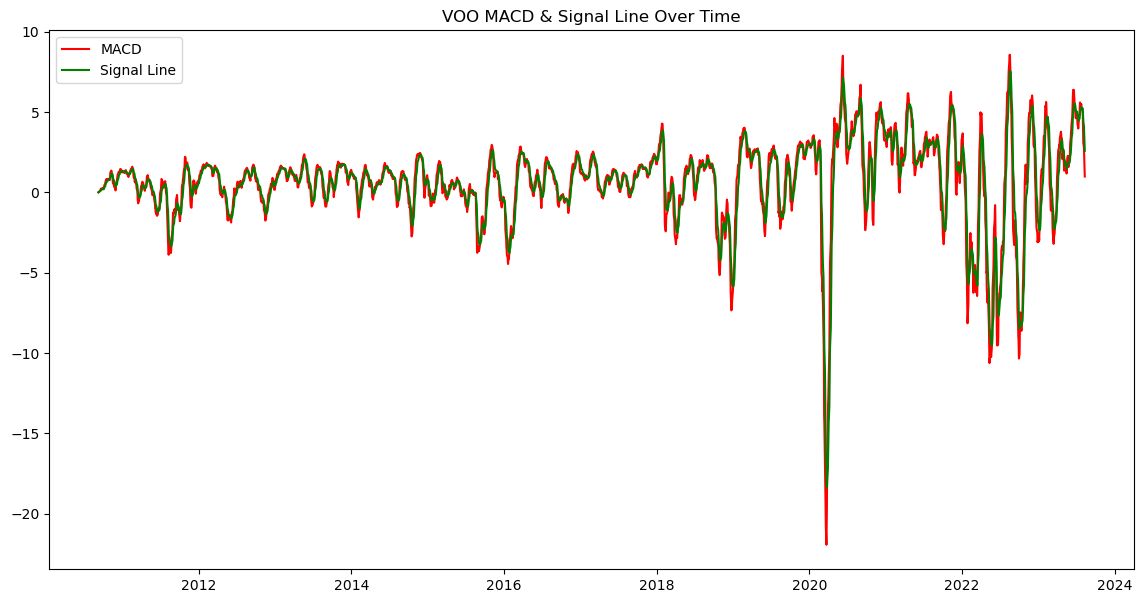

           Date       Open       High        Low      Close  Adj Close  \
3253 2003-08-18  47.299999  47.810001  47.299999  47.764999  32.965534   
3254 2003-08-19  48.000000  48.000000  47.674999  47.939999  33.086319   
3255 2003-08-20  47.849998  48.070000  47.750000  47.935001  33.082874   
3256 2003-08-21  48.145000  48.355000  47.980000  48.150002  33.231243   
3257 2003-08-22  48.544998  48.549999  47.605000  47.650002  32.886185   

      Volume Symbol                      Symbol_Name  SMA30  SMA100  RSI  \
3253  102400    VTI  Vanguard Total Stock Market ETF    NaN     NaN  NaN   
3254  287000    VTI  Vanguard Total Stock Market ETF    NaN     NaN  NaN   
3255  208400    VTI  Vanguard Total Stock Market ETF    NaN     NaN  NaN   
3256  199800    VTI  Vanguard Total Stock Market ETF    NaN     NaN  NaN   
3257  202800    VTI  Vanguard Total Stock Market ETF    NaN     NaN  NaN   

          EMA12      EMA26      MACD  Signal_Line  
3253  47.764999  47.764999  0.000000     0.000

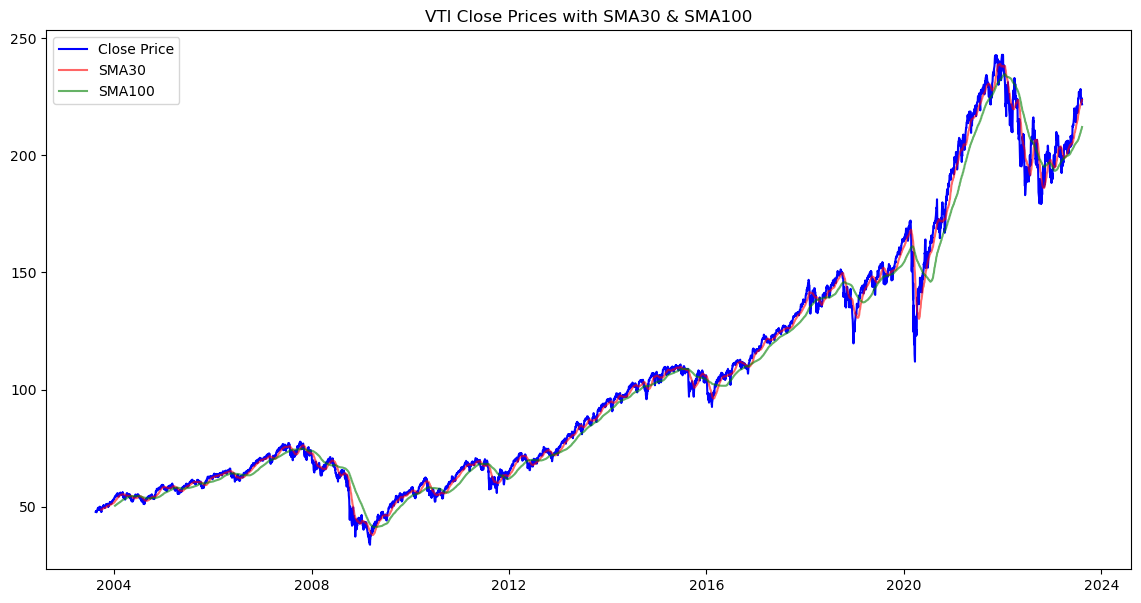

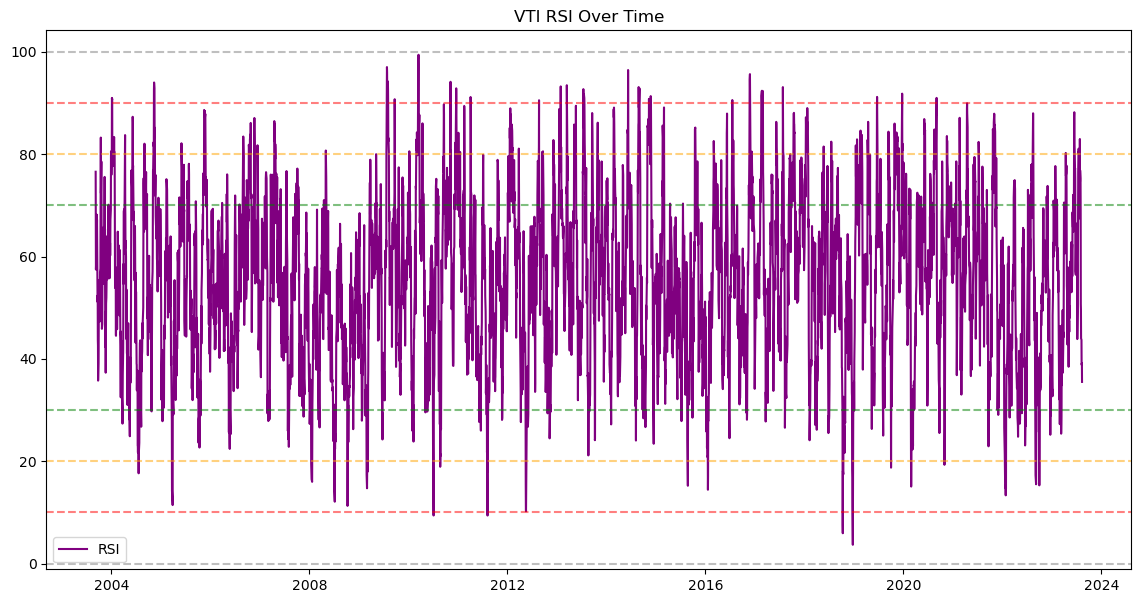

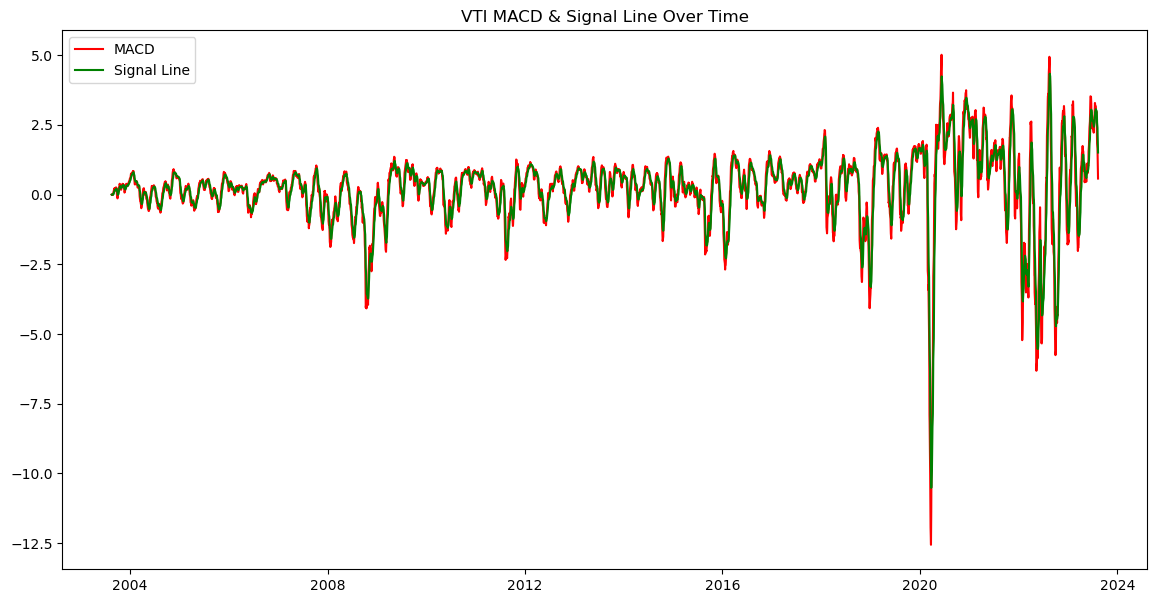

           Date       Open       High        Low      Close  Adj Close  \
8284 2004-01-30  48.740002  49.240002  48.740002  49.080002  41.682968   
8285 2004-02-02  49.099998  49.119999  48.840000  49.119999  41.716930   
8286 2004-02-03  48.799999  48.820000  48.619999  48.820000  41.462151   
8287 2004-02-04  47.500000  47.500000  47.349998  47.349998  40.213692   
8288 2004-02-05  47.700001  47.700001  47.349998  47.590000  40.417542   

      Volume Symbol                          Symbol_Name  SMA30  SMA100  RSI  \
8284  117600    VGT  Vanguard Information Technology ETF    NaN     NaN  NaN   
8285   65400    VGT  Vanguard Information Technology ETF    NaN     NaN  NaN   
8286  231100    VGT  Vanguard Information Technology ETF    NaN     NaN  NaN   
8287   51000    VGT  Vanguard Information Technology ETF    NaN     NaN  NaN   
8288    2600    VGT  Vanguard Information Technology ETF    NaN     NaN  NaN   

          EMA12      EMA26      MACD  Signal_Line  
8284  49.080002  49.08

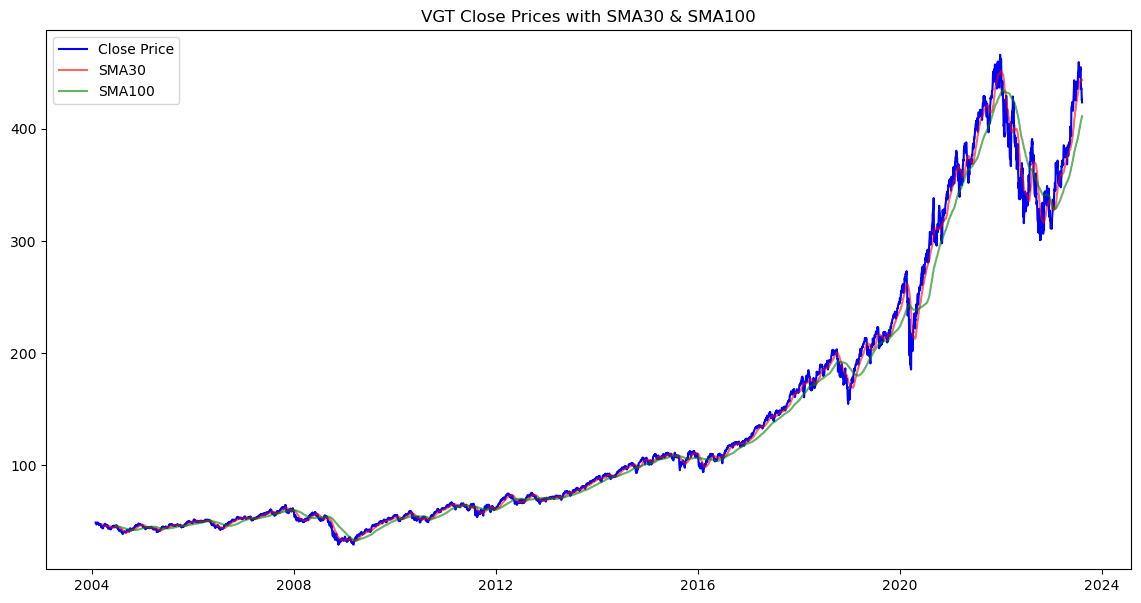

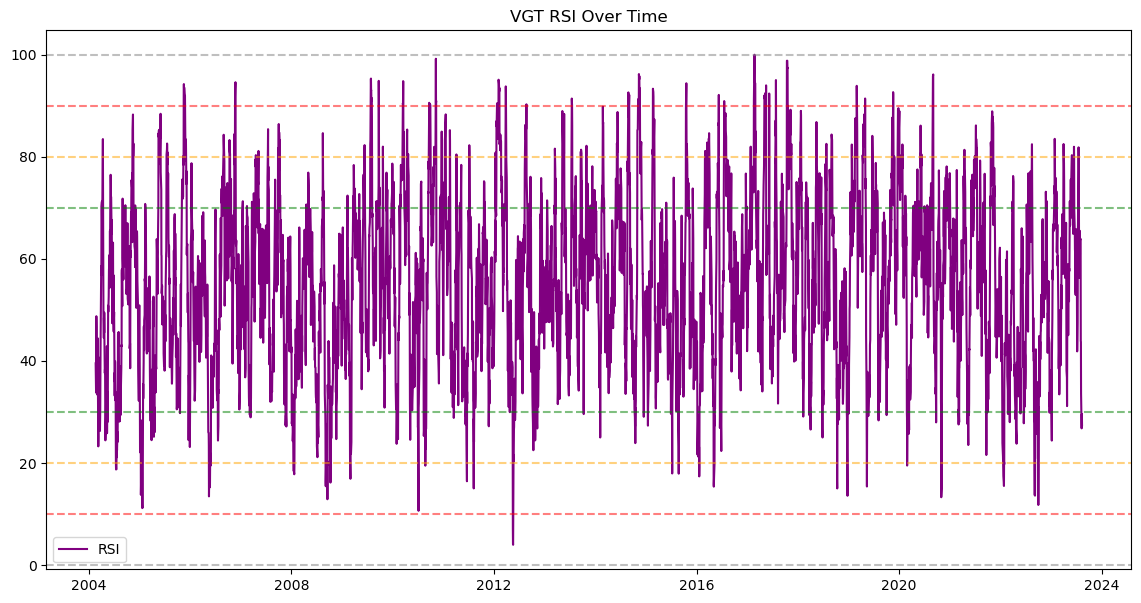

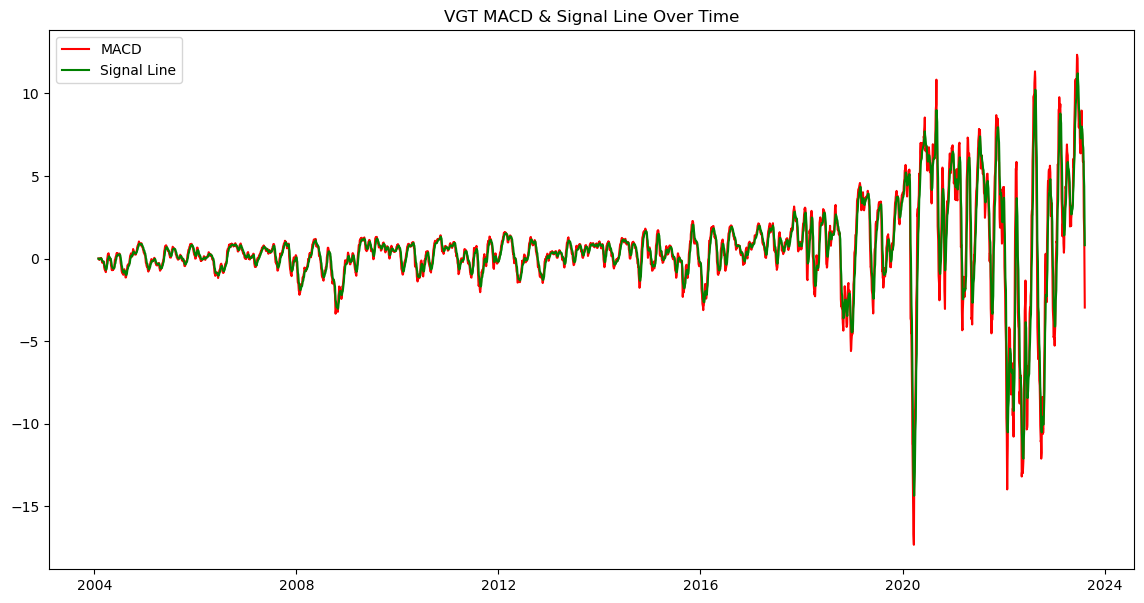

            Date       Open       High        Low      Close  Adj Close  \
13201 2004-01-30  49.520000  49.959999  49.520000  49.869999  32.805737   
13202 2004-02-02  49.980000  50.380001  49.889999  50.090000  32.950462   
13203 2004-02-03  50.049999  50.169998  50.009998  50.139999  32.983353   
13204 2004-02-04  49.919998  49.919998  49.680000  49.680000  32.680744   
13205 2004-02-05  49.660000  49.770000  49.490002  49.770000  32.739964   

       Volume Symbol              Symbol_Name  SMA30  SMA100  RSI      EMA12  \
13201  416600    VFH  Vanguard Financials ETF    NaN     NaN  NaN  49.869999   
13202    2300    VFH  Vanguard Financials ETF    NaN     NaN  NaN  49.989166   
13203    1400    VFH  Vanguard Financials ETF    NaN     NaN  NaN  50.048036   
13204    3400    VFH  Vanguard Financials ETF    NaN     NaN  NaN  49.931862   
13205    1000    VFH  Vanguard Financials ETF    NaN     NaN  NaN  49.887885   

           EMA26      MACD  Signal_Line  
13201  49.869999  0.000000

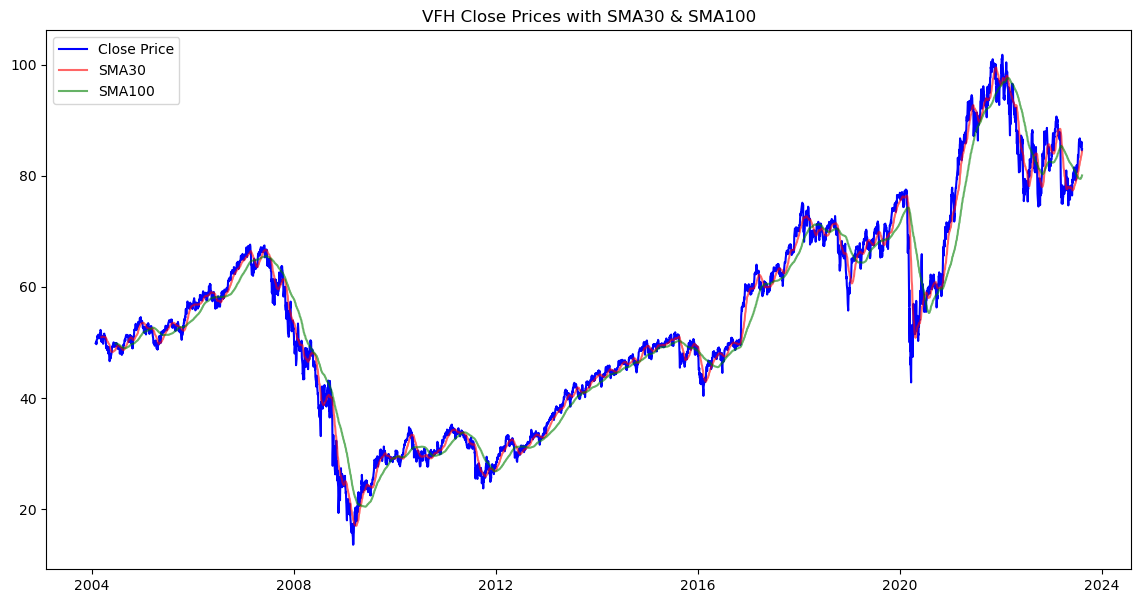

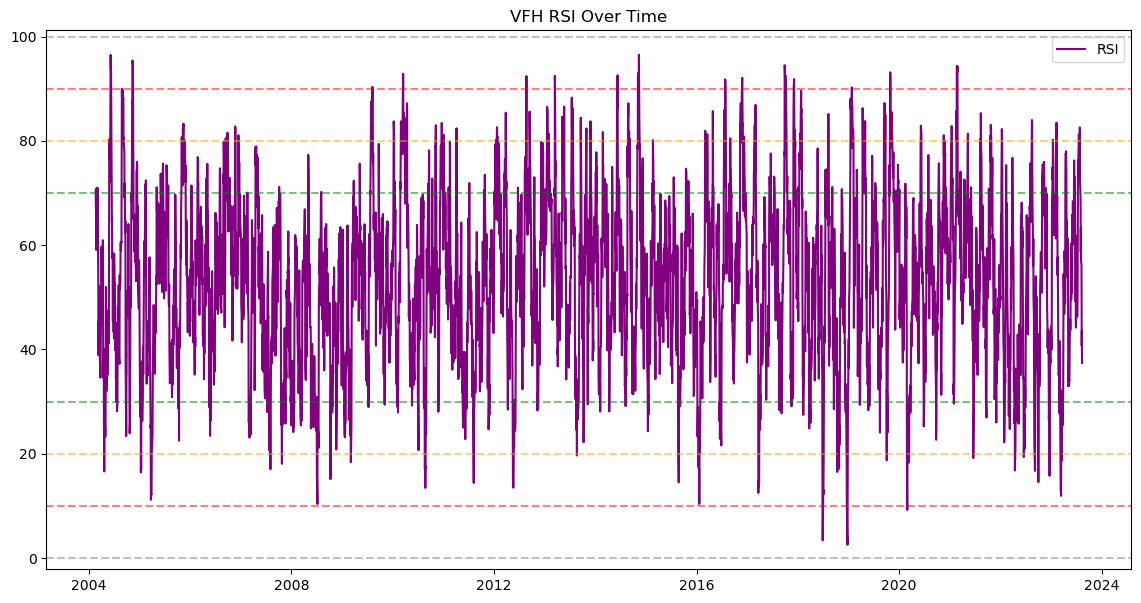

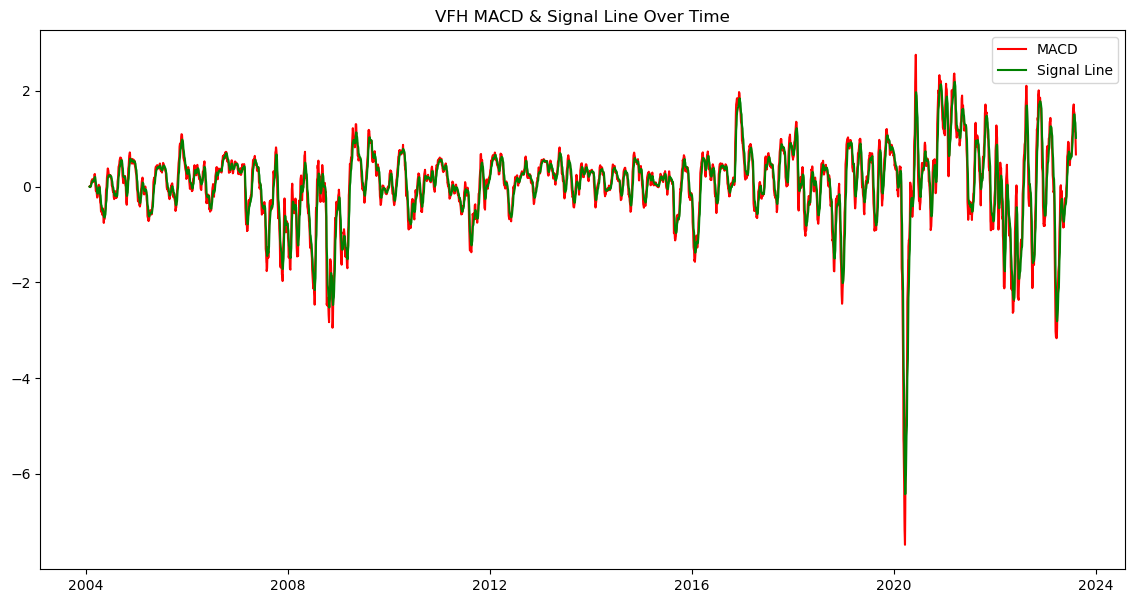

            Date       Open       High        Low      Close  Adj Close  \
18118 2004-01-30  49.869999  50.049999  49.750000  50.049999  38.570019   
18119 2004-02-02  50.099998  50.799999  49.980000  50.570000  38.970753   
18120 2004-02-03  50.549999  50.889999  50.500000  50.889999  39.217361   
18121 2004-02-04  50.779999  51.119999  50.759998  50.930000  39.248184   
18122 2004-02-05  50.930000  50.930000  50.450001  50.660000  39.040108   

       Volume Symbol               Symbol_Name  SMA30  SMA100  RSI      EMA12  \
18118   28700    VHT  Vanguard Health Care ETF    NaN     NaN  NaN  50.049999   
18119    8700    VHT  Vanguard Health Care ETF    NaN     NaN  NaN  50.331666   
18120    7300    VHT  Vanguard Health Care ETF    NaN     NaN  NaN  50.549584   
18121    8600    VHT  Vanguard Health Care ETF    NaN     NaN  NaN  50.669666   
18122   16300    VHT  Vanguard Health Care ETF    NaN     NaN  NaN  50.667040   

           EMA26      MACD  Signal_Line  
18118  50.049999  0.

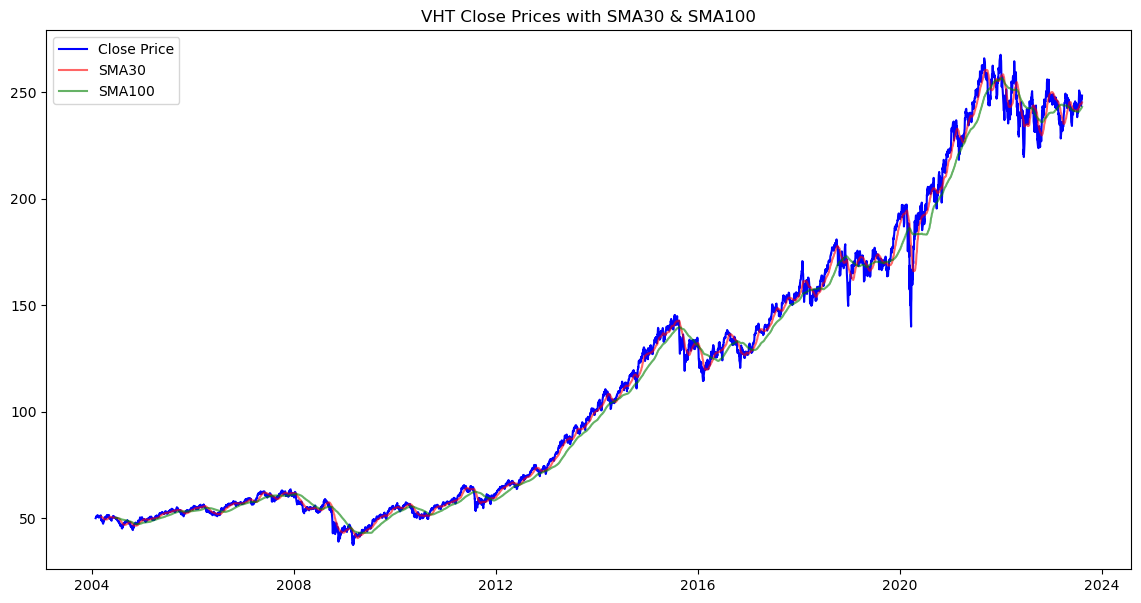

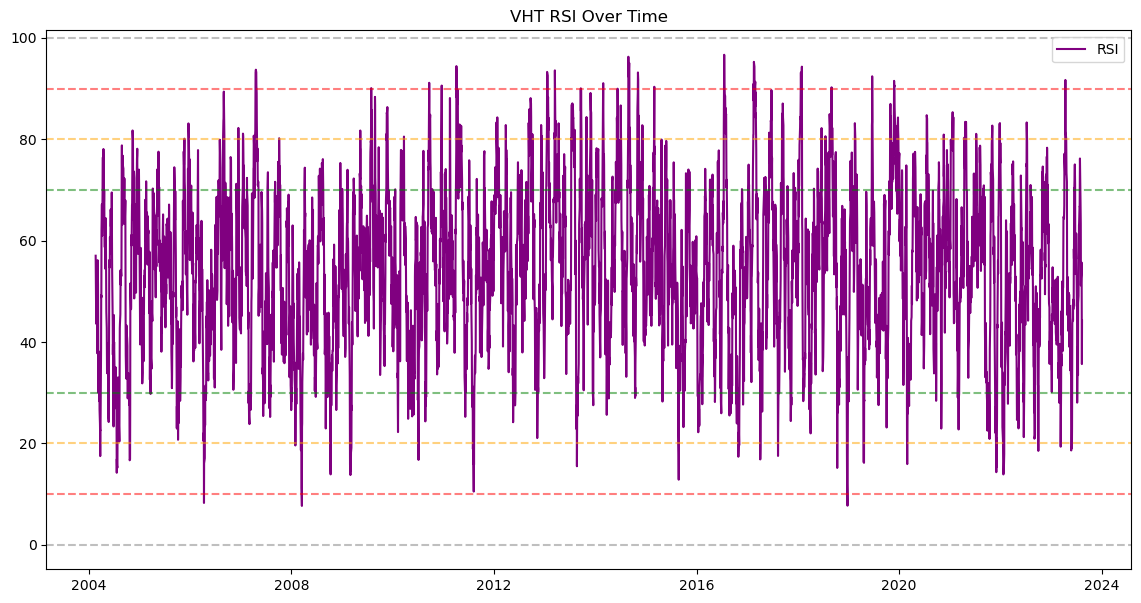

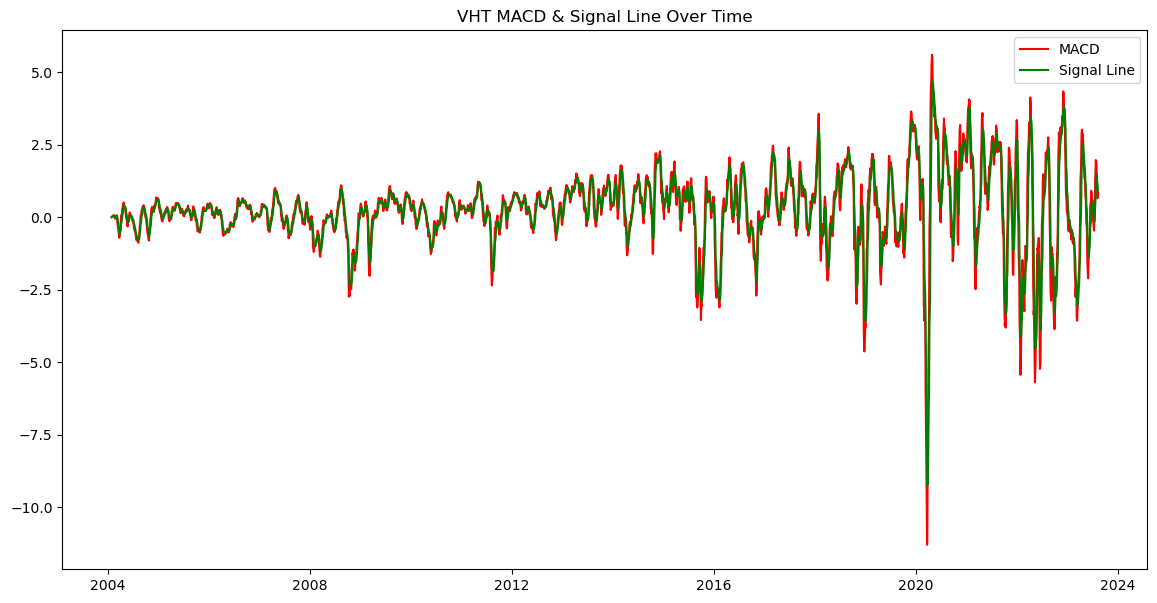

            Date       Open       High        Low      Close  Adj Close  \
23035 2004-09-29  48.889999  49.270000  48.889999  49.200001  37.006527   
23036 2004-09-30  49.279999  49.610001  49.279999  49.610001  37.314911   
23037 2004-10-01  49.610001  49.610001  49.610001  49.610001  37.314911   
23038 2004-10-04  50.590000  50.590000  50.529999  50.529999  38.006905   
23039 2004-10-05  50.270000  50.299999  50.270000  50.299999  37.833900   

       Volume Symbol               Symbol_Name  SMA30  SMA100  RSI      EMA12  \
23035   25800    VIS  Vanguard Industrials ETF    NaN     NaN  NaN  49.200001   
23036     400    VIS  Vanguard Industrials ETF    NaN     NaN  NaN  49.422084   
23037       0    VIS  Vanguard Industrials ETF    NaN     NaN  NaN  49.495428   
23038    3400    VIS  Vanguard Industrials ETF    NaN     NaN  NaN  49.822001   
23039     700    VIS  Vanguard Industrials ETF    NaN     NaN  NaN  49.951872   

           EMA26      MACD  Signal_Line  
23035  49.200001  0.

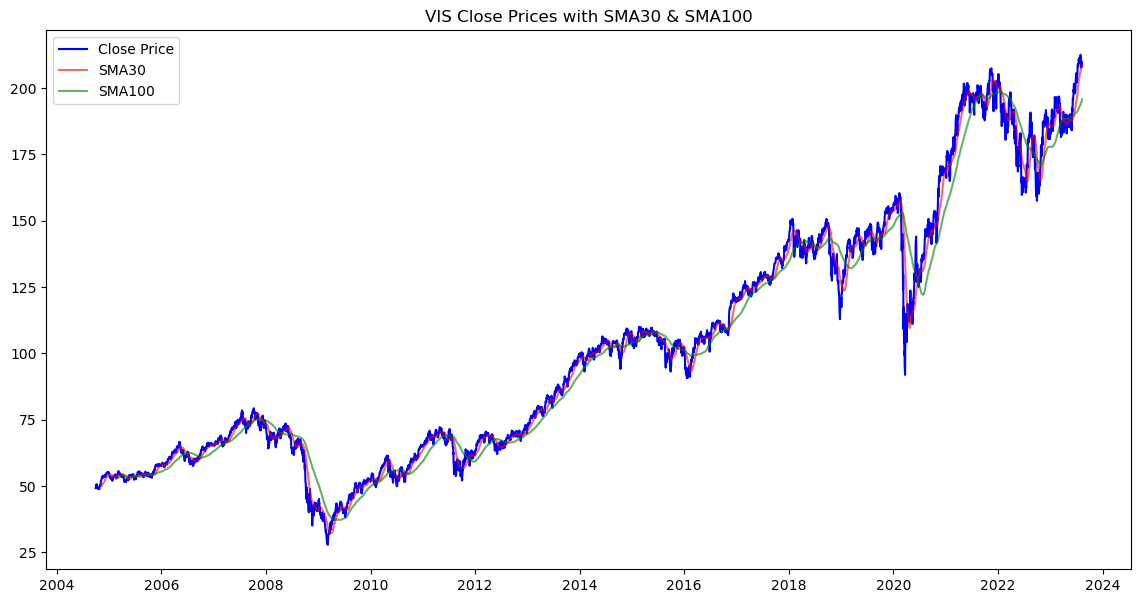

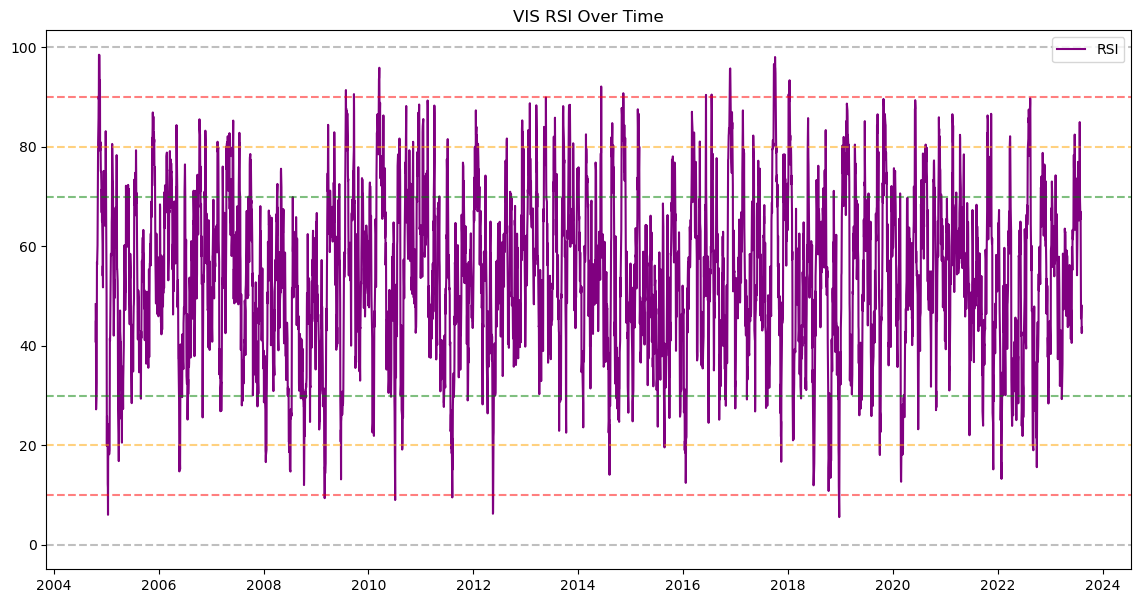

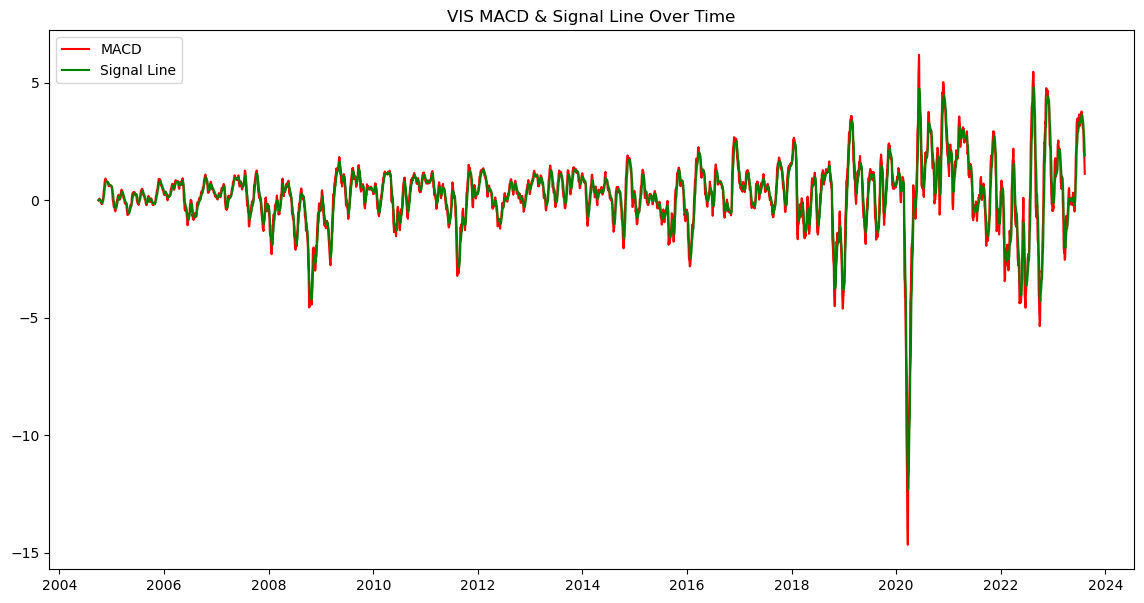

            Date       Open       High        Low      Close  Adj Close  \
27785 2004-01-30  48.630001  49.220001  48.630001  49.220001  34.534679   
27786 2004-02-02  49.200001  49.200001  49.049999  49.049999  34.415401   
27787 2004-02-03  48.900002  48.900002  48.700001  48.700001  34.169842   
27788 2004-02-04  48.549999  48.599998  48.299999  48.299999  33.889172   
27789 2004-02-05  48.500000  48.889999  48.500000  48.869999  34.289104   

       Volume Symbol             Symbol_Name  SMA30  SMA100  RSI      EMA12  \
27785    8700    VAW  Vanguard Materials ETF    NaN     NaN  NaN  49.220001   
27786    1300    VAW  Vanguard Materials ETF    NaN     NaN  NaN  49.127917   
27787    6900    VAW  Vanguard Materials ETF    NaN     NaN  NaN  48.960901   
27788    7100    VAW  Vanguard Materials ETF    NaN     NaN  NaN  48.752280   
27789   20900    VAW  Vanguard Materials ETF    NaN     NaN  NaN  48.784264   

           EMA26      MACD  Signal_Line  
27785  49.220001  0.000000     0

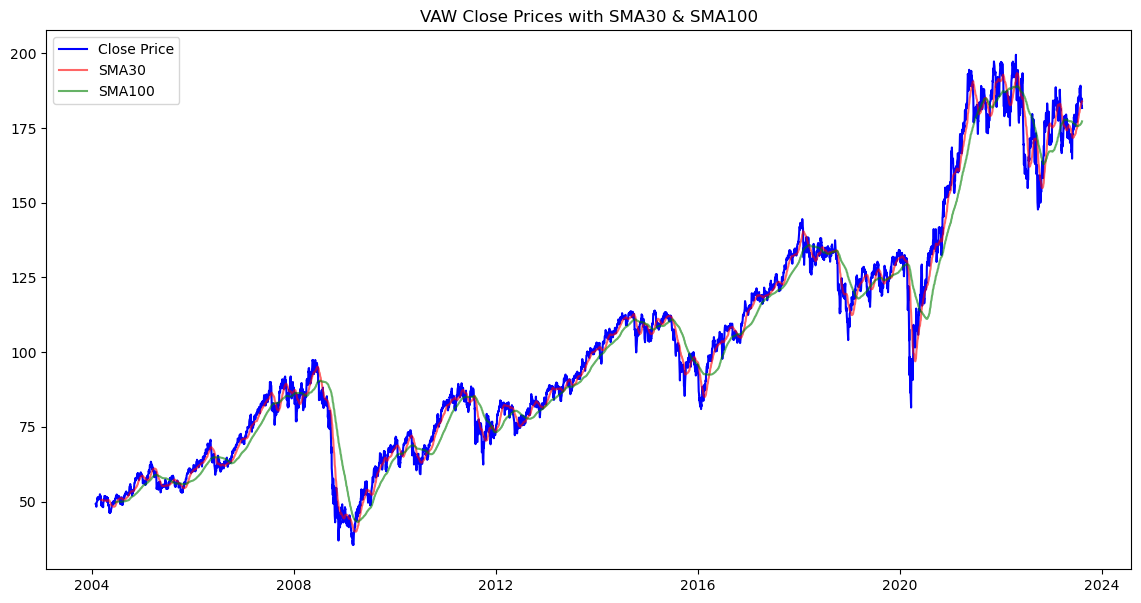

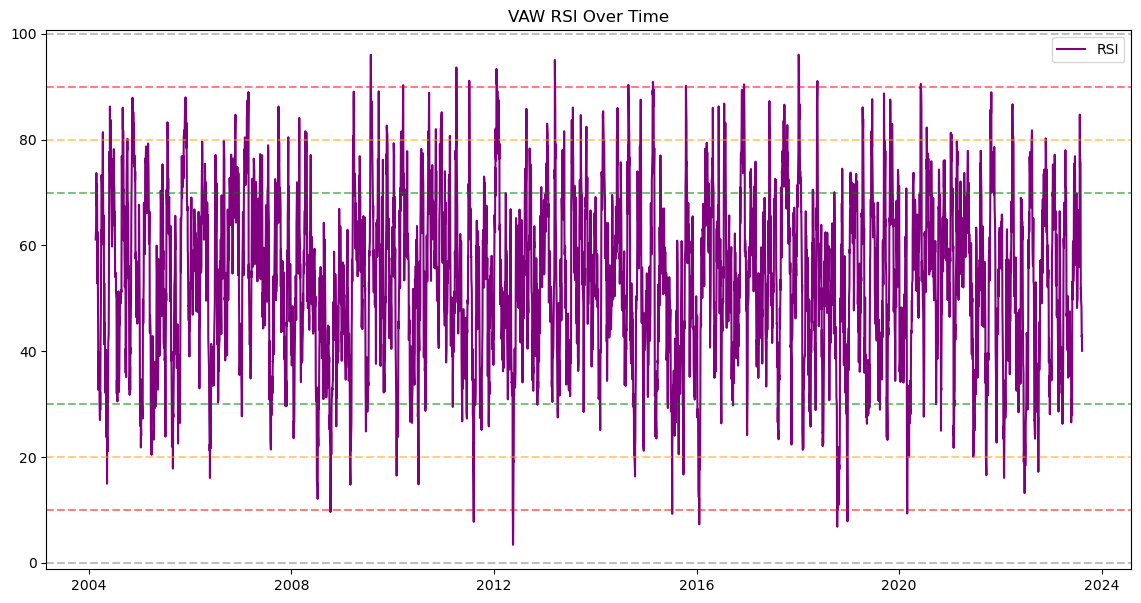

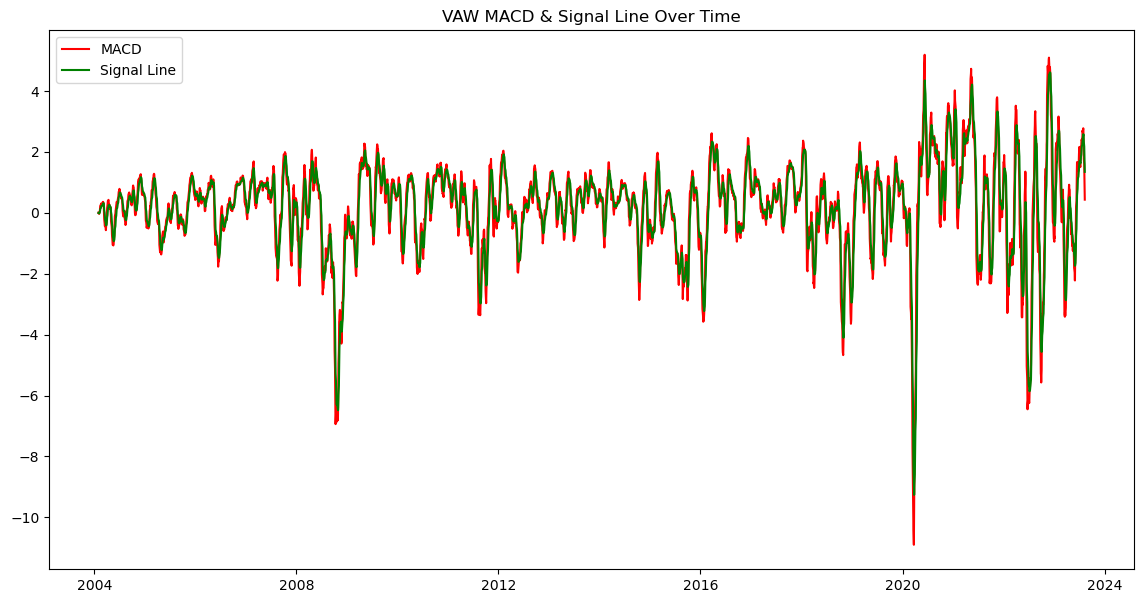

            Date       Open       High        Low      Close  Adj Close  \
32702 2004-09-29  49.849998  49.990002  49.840000  49.849998  21.955473   
32703 2004-09-30  50.000000  50.330002  49.990002  50.250000  22.131643   
32704 2004-10-01  50.349998  51.250000  50.250000  51.180000  22.541237   
32705 2004-10-04  51.389999  51.549999  51.389999  51.400002  22.638140   
32706 2004-10-05  51.400002  51.500000  51.349998  51.389999  22.633722   

       Volume Symbol               Symbol_Name  SMA30  SMA100  RSI      EMA12  \
32702  205800    VNQ  Vanguard Real Estate ETF    NaN     NaN  NaN  49.849998   
32703   27900    VNQ  Vanguard Real Estate ETF    NaN     NaN  NaN  50.066666   
32704  129800    VNQ  Vanguard Real Estate ETF    NaN     NaN  NaN  50.501201   
32705    8100    VNQ  Vanguard Real Estate ETF    NaN     NaN  NaN  50.784917   
32706   11900    VNQ  Vanguard Real Estate ETF    NaN     NaN  NaN  50.949316   

           EMA26      MACD  Signal_Line  
32702  49.849998  0.

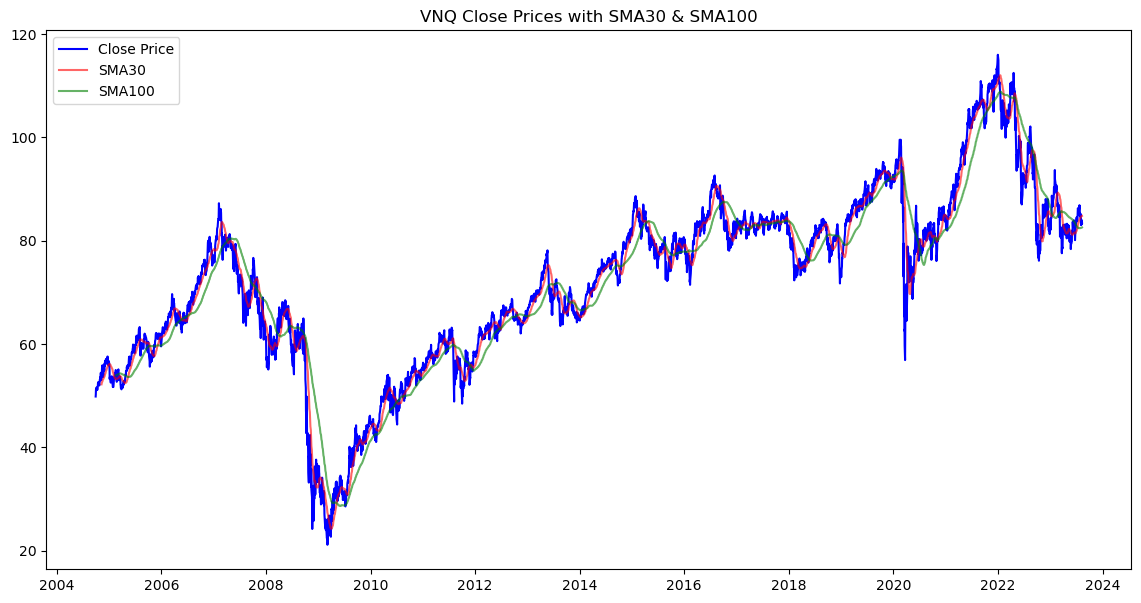

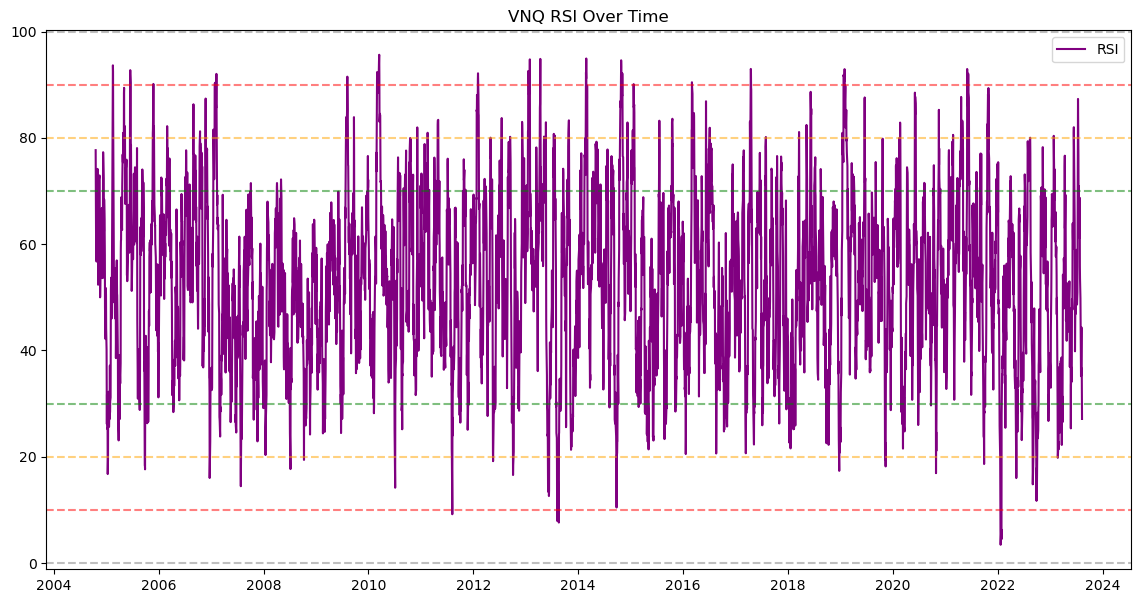

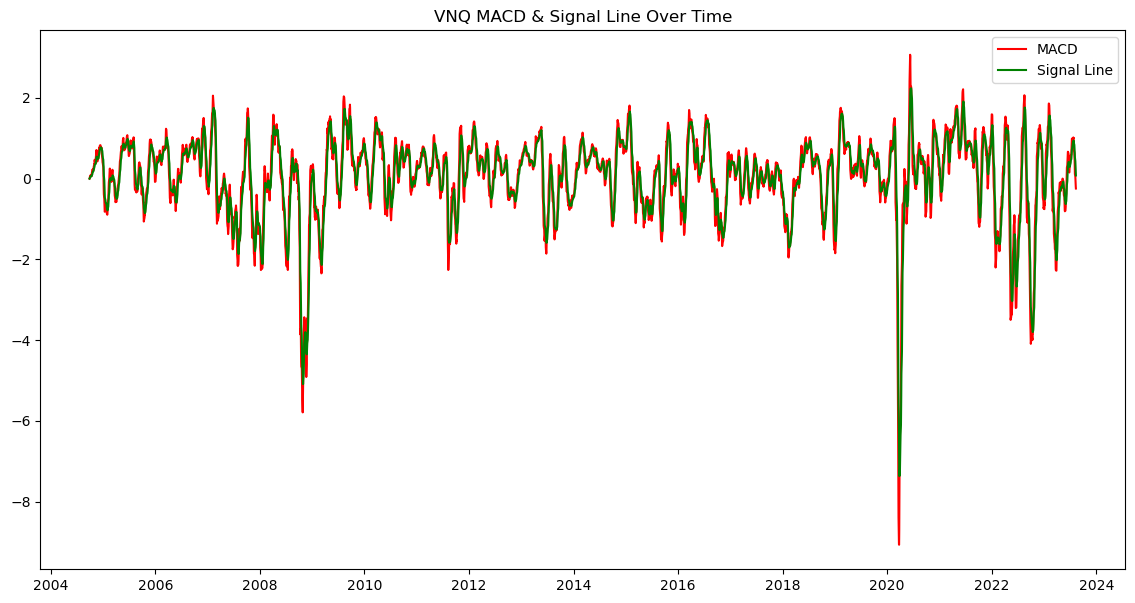

In [17]:
for symbol, df in data_by_symbol.items():
    df['SMA30'] = df['Close'].rolling(window=30).mean()
    df['SMA100'] = df['Close'].rolling(window=100).mean()
    df['RSI'] = compute_RSI(df['Close'])
    df['EMA12'] = df['Close'].ewm(span=12).mean()
    df['EMA26'] = df['Close'].ewm(span=26).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()
    print(df.head())

    # Plotting Closing Price, SMA30 and SMA100
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
    plt.plot(df['Date'], df['SMA30'], label='SMA30', color='red', alpha=0.6)
    plt.plot(df['Date'], df['SMA100'], label='SMA100', color='green', alpha=0.6)
    plt.title(f"{symbol} Close Prices with SMA30 & SMA100")
    plt.legend()
    plt.show()

    # Plotting RSI
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['RSI'], label='RSI', color='purple')
    plt.axhline(0, linestyle='--', alpha=0.5, color='gray')
    plt.axhline(10, linestyle='--', alpha=0.5, color='red')
    plt.axhline(20, linestyle='--', alpha=0.5, color='orange')
    plt.axhline(30, linestyle='--', alpha=0.5, color='green')
    plt.axhline(70, linestyle='--', alpha=0.5, color='green')
    plt.axhline(80, linestyle='--', alpha=0.5, color='orange')
    plt.axhline(90, linestyle='--', alpha=0.5, color='red')
    plt.axhline(100, linestyle='--', alpha=0.5, color='gray')
    plt.title(f"{symbol} RSI Over Time")
    plt.legend()
    plt.show()

    # Plotting MACD & Signal Line
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['MACD'], label='MACD', color='red')
    plt.plot(df['Date'], df['Signal_Line'], label='Signal Line', color='green')
    plt.title(f"{symbol} MACD & Signal Line Over Time")
    plt.legend()
    plt.show()


In [18]:
# Iterate over each symbol
for symbol, data in data_by_symbol.items():
    print(f"Processing data for symbol: {symbol}")

    # Split data into train and test set
    train_data, test_data = split_data(data)

    # Build ARIMA model
    model_arima = ARIMA(train_data['Close'], order=(5,1,0))
    model_arima_fit = model_arima.fit()

    # Make predictions
    predictions_arima = model_arima_fit.forecast(steps=5) # Forecast only for 10 days

    # Evaluate ARIMA model
    mse_arima = mean_squared_error(test_data['Close'], predictions_arima)

    # Prepare data for LSTM model
    X_train, y_train, X_test, y_test, scaler = prepare_data_for_lstm(data)

    # Build and train LSTM model
    model_lstm = build_and_train_lstm(X_train, y_train)

    # Make predictions with LSTM model
    predictions_lstm_scaled = model_lstm.predict(X_test)
    predictions_lstm = scaler.inverse_transform(predictions_lstm_scaled)

    # Inverse scale y_test
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate LSTM model
    mse_lstm = mean_squared_error(y_test, predictions_lstm_scaled)

    # Store results in dictionary
    results[symbol] = {
        'MSE_ARIMA': mse_arima,
        'Predictions_ARIMA': predictions_arima,
        'Real_Values': test_data['Close'].values,
        'MSE_LSTM': mse_lstm,
        'Predictions_LSTM_Diff': predictions_lstm,
        'LSTM_Real_Values': y_test_inv,
        'SMA30': test_data['SMA30'],
        'SMA100': test_data['SMA100']
    }



Processing data for symbol: VOO
1/1 [==============================] - 1s 728ms/step
Processing data for symbol: VTI
1/1 [==============================] - 1s 675ms/step
Processing data for symbol: VGT
1/1 [==============================] - 1s 675ms/step
Processing data for symbol: VFH
1/1 [==============================] - 1s 710ms/step
Processing data for symbol: VHT
1/1 [==============================] - 1s 674ms/step
Processing data for symbol: VIS
1/1 [==============================] - 1s 682ms/step
Processing data for symbol: VAW
1/1 [==============================] - 1s 678ms/step
Processing data for symbol: VNQ
1/1 [==============================] - 1s 678ms/step


Processing data for symbol: VOO
LSTM Model MSE: 0.0031460876192988046
Converted Predicted LSTM Values (Original Scale): [[0.28759247]
 [0.2486515 ]
 [0.2843775 ]
 [0.2722798 ]
 [0.2793418 ]]

Results for symbol: VOO
ARIMA Model MSE: 3.701670529808279
Predicted ARIMA Values: 0    410.684236
1    410.847935
2    410.824920
3    410.902353
4    410.836501
Name: predicted_mean, dtype: float64
Real Values: [414.07998657 412.29000854 409.54998779 409.79000854 409.41000366]
LSTM Model MSE: 0.008669164249871386


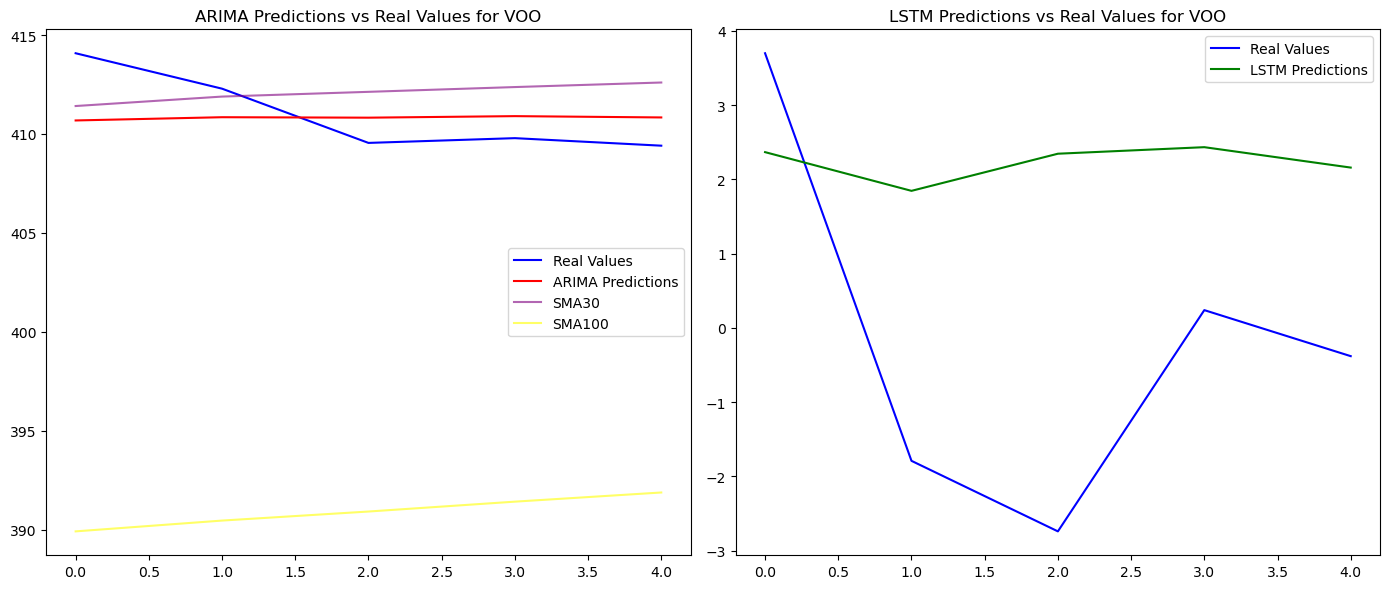

Processing data for symbol: VTI
LSTM Model MSE: 0.0031460876192988046
Converted Predicted LSTM Values (Original Scale): [[0.28759247]
 [0.2486515 ]
 [0.2843775 ]
 [0.2722798 ]
 [0.2793418 ]]

Results for symbol: VTI
ARIMA Model MSE: 1.4065124919625527
Predicted ARIMA Values: 0    223.012564
1    223.108418
2    223.099912
3    223.134252
4    223.114172
Name: predicted_mean, dtype: float64
Real Values: [224.61000061 223.57000732 221.97000122 222.00999451 221.80000305]
LSTM Model MSE: 0.007069282238098801


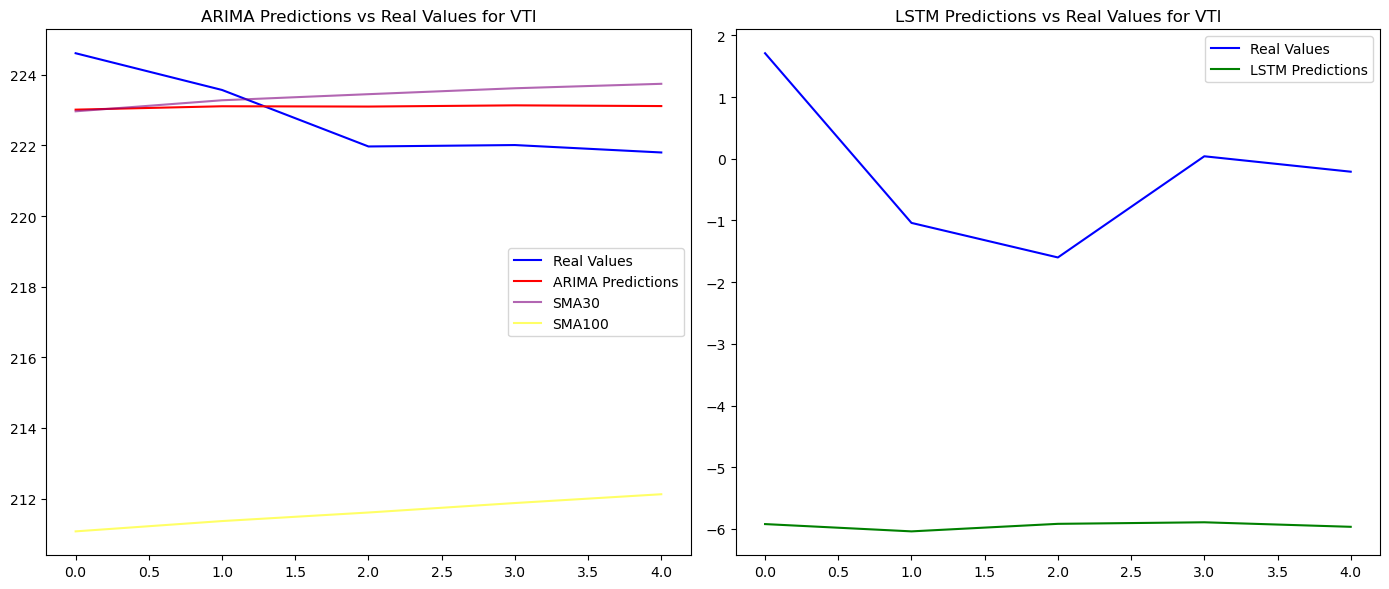

Processing data for symbol: VGT
LSTM Model MSE: 0.0031460876192988046
Converted Predicted LSTM Values (Original Scale): [[0.28759247]
 [0.2486515 ]
 [0.2843775 ]
 [0.2722798 ]
 [0.2793418 ]]

Results for symbol: VGT
ARIMA Model MSE: 81.62096237412588
Predicted ARIMA Values: 0    436.224064
1    436.711212
2    436.627228
3    436.794374
4    436.609688
Name: predicted_mean, dtype: float64
Real Values: [436.16000366 432.1000061  426.04998779 426.45001221 423.6499939 ]
LSTM Model MSE: 0.017290573576431434


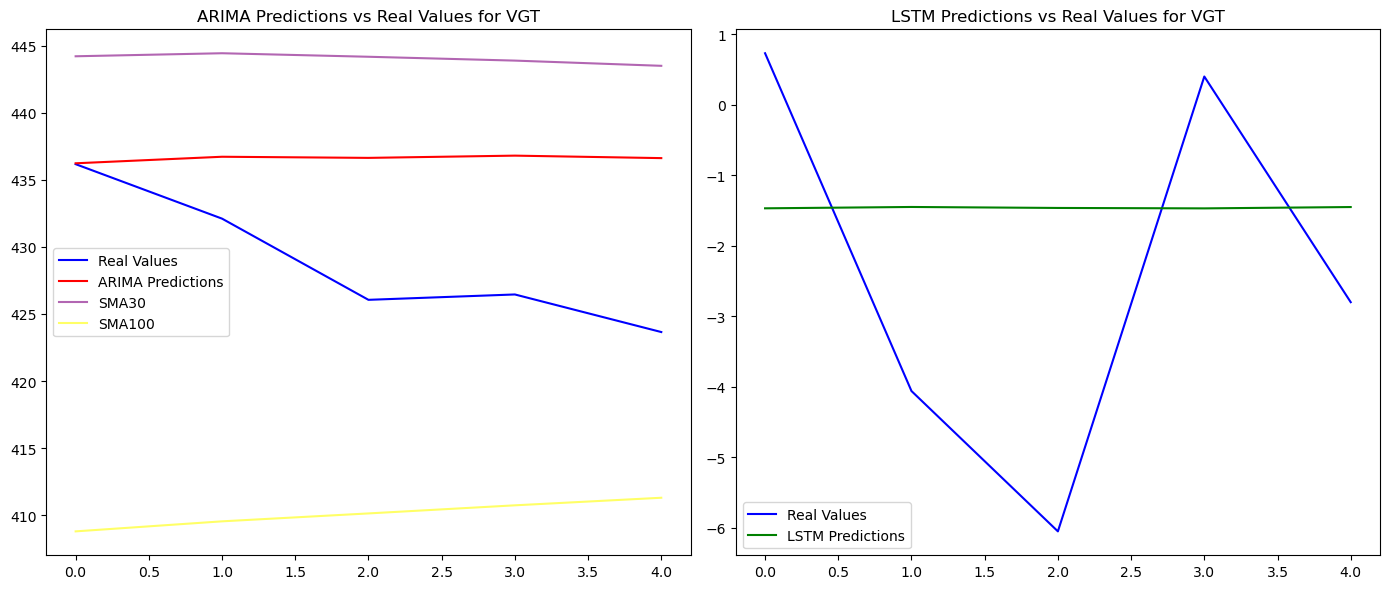

Processing data for symbol: VFH
LSTM Model MSE: 0.0031460876192988046
Converted Predicted LSTM Values (Original Scale): [[0.28759247]
 [0.2486515 ]
 [0.2843775 ]
 [0.2722798 ]
 [0.2793418 ]]

Results for symbol: VFH
ARIMA Model MSE: 0.34171179371986543
Predicted ARIMA Values: 0    85.121642
1    85.140615
2    85.140123
3    85.152408
4    85.150903
Name: predicted_mean, dtype: float64
Real Values: [86.09999847 85.19999695 84.55999756 84.66000366 84.73999786]
LSTM Model MSE: 0.009692194553383292


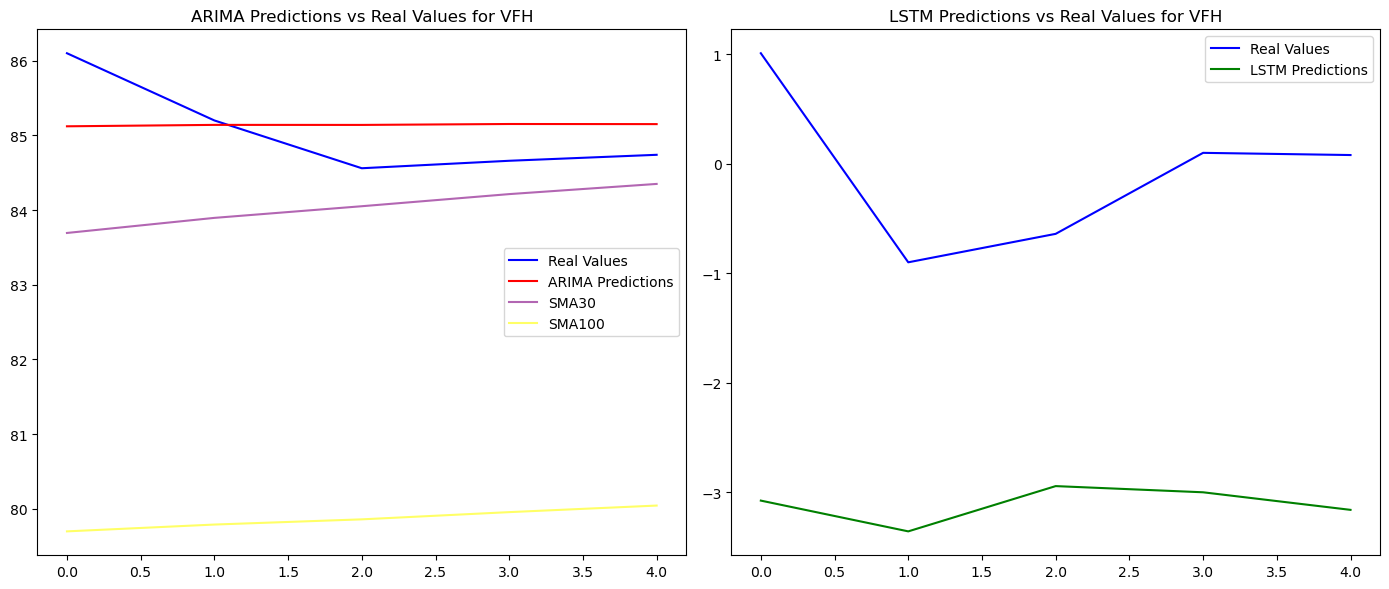

Processing data for symbol: VHT
LSTM Model MSE: 0.0031460876192988046
Converted Predicted LSTM Values (Original Scale): [[0.28759247]
 [0.2486515 ]
 [0.2843775 ]
 [0.2722798 ]
 [0.2793418 ]]

Results for symbol: VHT
ARIMA Model MSE: 13.25384031597224
Predicted ARIMA Values: 0    243.522939
1    243.489191
2    243.555751
3    243.530701
4    243.520323
Name: predicted_mean, dtype: float64
Real Values: [245.57000732 247.30000305 247.11999512 246.94000244 248.33999634]
LSTM Model MSE: 0.00877479611014991


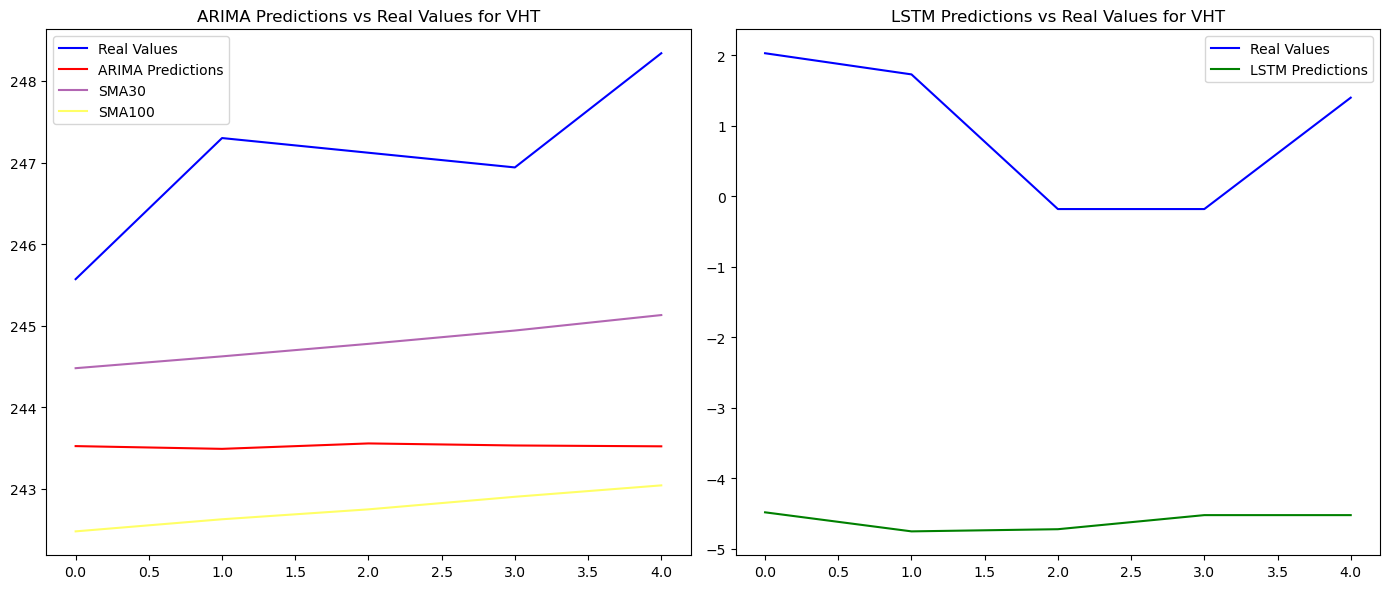

Processing data for symbol: VIS
LSTM Model MSE: 0.0031460876192988046
Converted Predicted LSTM Values (Original Scale): [[0.28759247]
 [0.2486515 ]
 [0.2843775 ]
 [0.2722798 ]
 [0.2793418 ]]

Results for symbol: VIS
ARIMA Model MSE: 1.5855004334100389
Predicted ARIMA Values: 0    207.735803
1    207.813198
2    207.846483
3    207.858084
4    207.840248
Name: predicted_mean, dtype: float64
Real Values: [210.11999512 209.02000427 208.58999634 208.08000183 208.27000427]
LSTM Model MSE: 0.009799659491851558


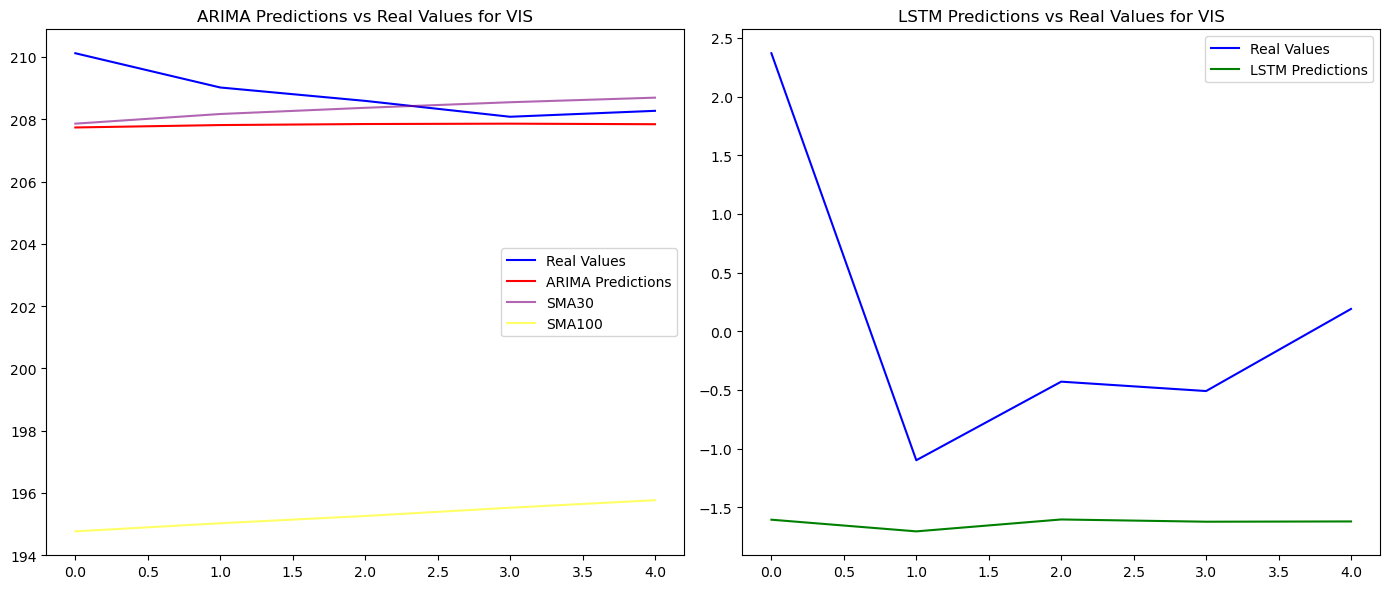

Processing data for symbol: VAW
LSTM Model MSE: 0.0031460876192988046
Converted Predicted LSTM Values (Original Scale): [[0.28759247]
 [0.2486515 ]
 [0.2843775 ]
 [0.2722798 ]
 [0.2793418 ]]

Results for symbol: VAW
ARIMA Model MSE: 2.4601375453510195
Predicted ARIMA Values: 0    183.779027
1    183.865001
2    183.902349
3    183.916991
4    183.915188
Name: predicted_mean, dtype: float64
Real Values: [184.97999573 183.16000366 182.25999451 182.27000427 181.69000244]
LSTM Model MSE: 0.013330043603366875


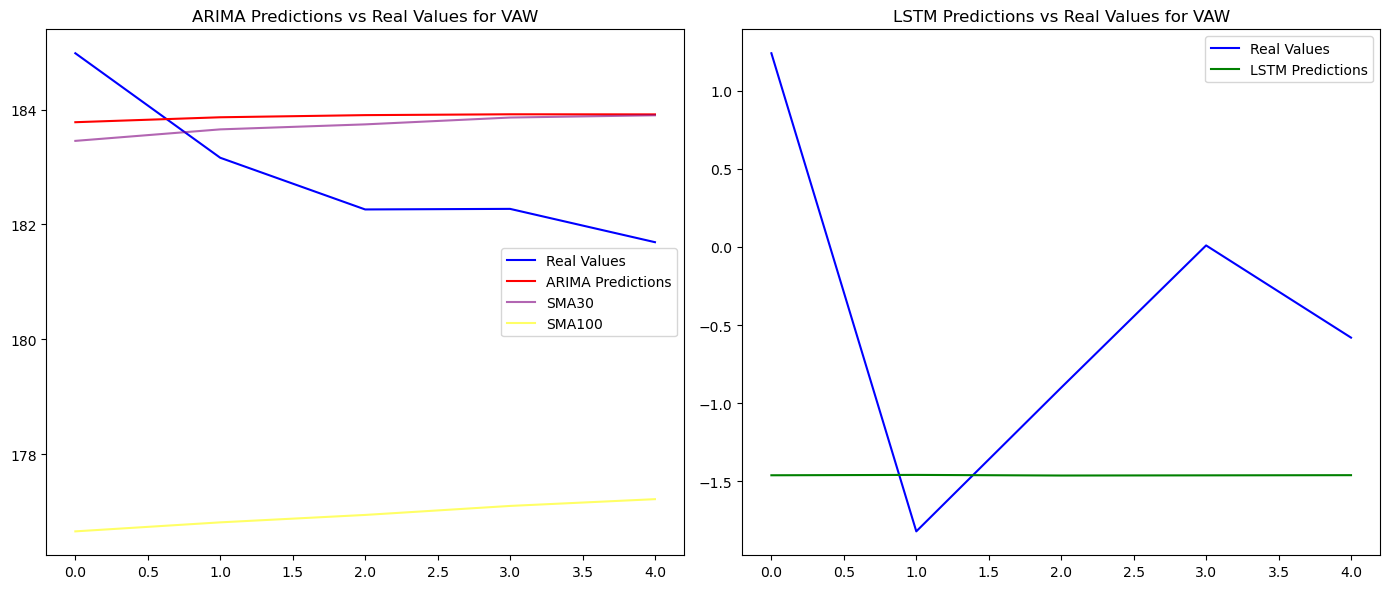

Processing data for symbol: VNQ
LSTM Model MSE: 0.0031460876192988046
Converted Predicted LSTM Values (Original Scale): [[0.28759247]
 [0.2486515 ]
 [0.2843775 ]
 [0.2722798 ]
 [0.2793418 ]]

Results for symbol: VNQ
ARIMA Model MSE: 0.29335055592866843
Predicted ARIMA Values: 0    83.062302
1    83.053926
2    83.097545
3    83.131787
4    83.126202
Name: predicted_mean, dtype: float64
Real Values: [84.06999969 83.52999878 83.51999664 83.19999695 83.33000183]
LSTM Model MSE: 0.0031460876192988046


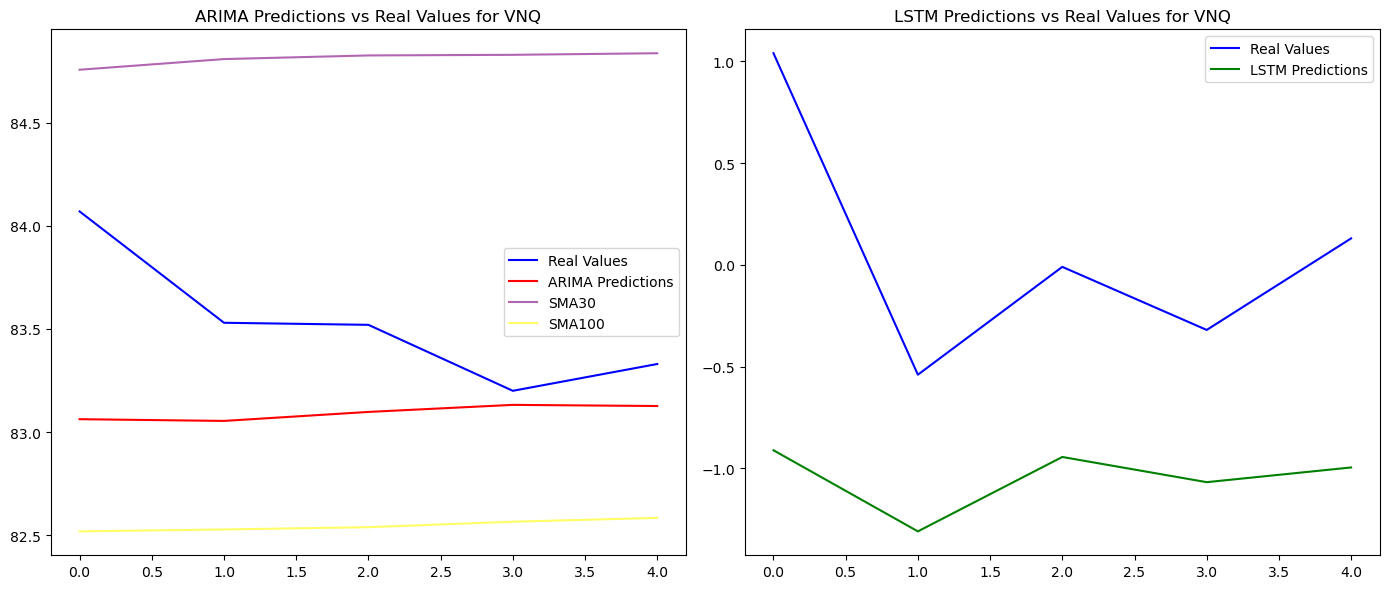

In [19]:
for symbol, result in results.items():
    print(f"Processing data for symbol: {symbol}")
    
    # Reset indexes
    result['Predictions_ARIMA'] = result['Predictions_ARIMA'].reset_index(drop=True)
    result['SMA30'] = result['SMA30'].reset_index(drop=True)
    result['SMA100'] = result['SMA100'].reset_index(drop=True)
    # Inverse transform the scaled predictions
    predictions_lstm_original = scaler.inverse_transform(predictions_lstm_scaled)
    print("LSTM Model MSE:", mse_lstm)
    print("Converted Predicted LSTM Values (Original Scale):", predictions_lstm_original)

    result['Predictions_LSTM'] = scaler.inverse_transform(result['Predictions_LSTM_Diff'])

    # Fetching Technical Indicators for the symbol
    stock_data = df[df['Symbol'] == symbol]

    print(f"\nResults for symbol: {symbol}")
    print(f"ARIMA Model MSE: {result['MSE_ARIMA']}")
    print(f"Predicted ARIMA Values: {result['Predictions_ARIMA']}")
    print(f"Real Values: {result['Real_Values']}")
    print(f"LSTM Model MSE: {result['MSE_LSTM']}")

    # Plot the results
    plt.figure(figsize=(14, 6))
    
    # ARIMA predictions
    plt.subplot(1, 2, 1)
    plt.plot(result['Real_Values'], label='Real Values', color='blue')
    plt.plot(result['Predictions_ARIMA'], label='ARIMA Predictions', color='red')
    plt.plot(result['SMA30'], label='SMA30', color='purple', alpha=0.6)
    plt.plot(result['SMA100'], label='SMA100', color='yellow', alpha=0.6)
    plt.title(f"ARIMA Predictions vs Real Values for {symbol}")
    plt.legend()
    
    # LSTM predictions
    plt.subplot(1, 2, 2)
    plt.plot(result['LSTM_Real_Values'], label='Real Values', color='blue')
    plt.plot(result['Predictions_LSTM'].flatten(), label='LSTM Predictions', color='green')
    plt.title(f"LSTM Predictions vs Real Values for {symbol}")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
